## Script for topic modelling on hashtags

* LDA models
* Number of topics
* Consistency
* Word count 
* Distribution
* LDA visualisation

*Special thanks to Leo Dray for explaining and share is model of topic modelling (made for anticipation litterature) and Michel Capot for his precious advices*


In [1]:
# Use the correct environnement - python 3.6.9 is recommended with the packages below

from platform import python_version
print(python_version())

3.6.9


In [2]:
import pandas as pd
import os
import io
import re
from typing import List
import numpy as np
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.corpora.mmcorpus import MmCorpus
from gensim.test.utils import datapath
from pprintpp import pprint
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from collections import Counter
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import pyLDAvis.gensim
from tqdm import tqdm
import Pyro4

## 1) Dataframe manipulation

* Import and prepare dataframe
* Possibly try different length of hashtags per posts (is it significant in the analysis ?)
* Transform it to a list of words
* Save the list to a file/ Load another file than a datafram

In [3]:
# Load dataframe
# Here for one line you have 'id' related to images and 'txt' from the hashtags

df = pd.read_csv(' ')
df = df.drop('Unnamed: 0', 1) # drop unwanted column
df

,Unnamed: 0.1,name,country,street,zip,city_one,city_two,region,date,likes,...,id,year,month,day,txt,split,0,1,2,3
0,49,Algeria,DZ,90,NaN,El Kala,NaN,NaN,2020-08-04,37.0,...,2.020080e+13,2020.0,8.0,4.0,venus parfum parfume beautiful beauty santé co...,23,0.157386,0.000000,0.826356,0.000000
1,56,Algeria,DZ,"80,rue du 17 Septembre 1956",09100,Oulad Ya\u00efch,Blida,NaN,2020-08-17,31.0,...,2.020082e+13,2020.0,8.0,17.0,laboratoires moussededouchevenus جمال جمال gel...,17,0.157389,0.000000,0.826353,0.000000
2,138,Argentina,AR,NaN,B 6000,Jun\u00edn,Buenos Aires,NaN,2020-04-29,11.0,...,2.020043e+13,2020.0,4.0,29.0,planetas planetavenus venus,3,0.018152,0.018171,0.943400,0.020277
3,349,Argentina,AR,NaN,NaN,NaN,NaN,Ciudad Aut\u00f3noma de Buenos Aires,2020-07-24,462.0,...,2.020072e+13,2020.0,7.0,24.0,sol leo virgo libra marte aries mercurio cánce...,20,0.134974,0.012781,0.839083,0.013162
4,392,Argentina,AR,NaN,NaN,Boedo,NaN,NaN,2020-08-13,24.0,...,2.020081e+13,2020.0,8.0,13.0,sailorvenus venus sailorv sailorvenusedit sail...,30,0.000000,0.000000,0.934627,0.047140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6180,53979,Namibia,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-09,18.0,...,2.020051e+13,2020.0,5.0,9.0,venus venere dove deadellabellezza goddess gre...,18,0.000000,0.000000,0.832052,0.151625
6181,53981,Namibia,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-09,32.0,...,2.020051e+13,2020.0,5.0,9.0,orgonit orgoniti orgon orgonskaenergija orgons...,33,0.024402,0.000000,0.959000,0.000000
6182,54063,Namibia,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-09,19.0,...,2.020051e+13,2020.0,5.0,9.0,theemperor venus jupiter tzadkielangel swordfe...,29,0.000000,0.107232,0.840710,0.043940
6183,54100,Namibia,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-09,10.0,...,2.020051e+13,2020.0,5.0,9.0,semtabu lubrificantes produtoseroticos hotflow...,18,0.000000,0.000000,0.975708,0.000000


We try some ways to split the Dataframe:

* By number of words per post
* By localisation (countries)
* By days

Then see what is significant or not with topic modeling method

In [4]:
# Describe words per post

print(df.split.describe())

count    6185.000000
mean       15.133711
std         9.981147
min         1.000000
25%         6.000000
50%        13.000000
75%        24.000000
max        60.000000
Name: split, dtype: float64


In [5]:
# Describe likes per post

print(df.likes.describe())

count     6185.000000
mean        94.066774
std        718.399014
min          0.000000
25%         11.000000
50%         24.000000
75%         53.000000
max      45871.000000
Name: likes, dtype: float64


In [9]:
# About coutries

(df.name.value_counts())[1:21]

Brazil                      174
France                       76
India                        74
Germany                      50
Italy                        36
Iran Islamic Republic of     36
Colombia                     29
Canada                       26
Indonesia                    25
Japan                        17
Chile                        13
Mexico                       11
Ecuador                       9
Croatia                       7
Greece                        7
Costa Rica                    5
Israel                        5
Argentina                     4
Denmark                       4
Korea Republic of             4
Name: name, dtype: int64

In [10]:
# Try different length of words per posts (row), or country, likes, etc.
# Then build a list (all posts) of lists (hashtags per posts)

#df = df[(df['name'] == 'United States')] # here we try the United States
#dff = df[(df['split'] > 27)] # last quartile
#dff = df[(df['likes'] > 54)] # last quartile

list_hashtags = []

for i in df.txt:
    list_hashtags.append(i)

In [ ]:
# Or load '.txt' file

#list_hashtags = open(r"","w+")

In [11]:
# Text or list to a list of words

def get_words(text):
    
    words = text.split(" ")
    return words

# In our case it's still a list of list but words are now set as words

final_list = []
for e in list_hashtags:
    l = []
    l = get_words(e)
    final_list.append(l)

In [ ]:
# We also try without the main hashtag

char_list = ['venus']
final_list = [l for l in final_list if all(ch not in l for ch in char_list)] 

## 2) Topic modelling functions

* Topic number consistency
* LDA with TF-IDF
* LDA with Gensim
* Model to Dataframe
* Wordcloud
* LDAvis

*At first all the functions are explained, then you can use them at the next step*

In [12]:
# LDA model with TF-IDF


def model_LDA_tfidf(list_lemma, num_topics: int, passes: int, workers: int, printer='False'):

    # Create a Gensim dictionary
    array_lemma = np.array(list_lemma)
    dictionary = gensim.corpora.Dictionary(array_lemma)

    # Create a 'bag of words' with doc2bow function
    bow_corpus = [dictionary.doc2bow(doc) for doc in array_lemma]

    # Corpus creation based on a 'bag of words'
    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]


    # Model learning 
    lda_model = gensim.models.LdaMulticore(corpus_tfidf, id2word=dictionary, num_topics=num_topics, passes=passes, workers=workers)

    if printer=='True':
        pprint(lda_model.print_topics())

    return lda_model, bow_corpus

In [13]:
# LDA model with Gensim

def model_LDA_gensim(list_lemma, num_topics: int, passes: int, iterations: int, printer='False'):

    # Creat a Gensim dictionary
    array_lemma = np.array(list_lemma)
    dictionary = gensim.corpora.Dictionary(array_lemma)

    # Create a 'bag of words' with doc2bow function
    bow_corpus = [dictionary.doc2bow(doc) for doc in array_lemma]

    # Model learning 
    lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, id2word=dictionary,num_topics=num_topics, random_state=100, update_every=1, chunksize=1000, passes=passes, alpha='symmetric', iterations=iterations, per_word_topics=True)

    if printer == 'True':
        pprint(lda_model.print_topics())

    return lda_model, bow_corpus

In [14]:
# Calcul coherence of the model

def model_coherence(lda_model, list_lemma):

    # Creat Gensim dictionary
    array_lemma = np.array(list_lemma)
    dic_gensim = gensim.corpora.Dictionary(array_lemma)

    # Score consistency
    coherence_model_lda = CoherenceModel(model=lda_model, texts=list_lemma, dictionary=dic_gensim, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    return coherence_lda

In [15]:
# Choose best topic number for TF-IDF model

def best_topics_tfidf(list_lemma, max_num:int, passes:int, workers:int):
    
    list_model = []
    list_bow = []
    list_coherence = []
    list_topic_number = []
    
    for i in tqdm(range(max_num)):
        model, bow = model_LDA_tfidf(list_lemma, num_topics=i+1, passes=passes, workers=workers)
        list_model.append(model)
        list_bow.append(bow)
        list_coherence.append(model_coherence(model, list_lemma))
        list_topic_number.append(i+1)

        #Plot number of topics (x) by coherence (y)
    fig = plt.figure(figsize=(7,5))
    ax1 = fig.add_subplot(1,1,1)
    x = np.array(list_topic_number)
    y = np.array(list_coherence)
    plt.plot(x, y)
    ax1.set_ylabel("Number of topics")
    ax1.set_ylabel("Coherence score")
    ax1.xaxis.set_major_locator(ticker.AutoLocator())
    plt.title("Coherence score by topics number for {} passes for TF-IDF".format(passes))
    plt.show()
        
    return fig, list_model, list_bow   

In [16]:
# Choose best topic number for Gensim model

def best_topics_gensim(list_lemma, max_num:int, passes:int, iterations:int):
    
    list_model = []
    list_bow = []
    list_coherence = []
    list_topic_number = []
    
    for i in tqdm(range(max_num)):
        model, bow = model_LDA_gensim(list_lemma, num_topics=i+1, passes=passes, iterations=iterations)
        list_model.append(model)
        list_bow.append(bow)
        list_coherence.append(model_coherence(model, list_lemma))
        list_topic_number.append(i+1)

        #Plot number of topics (x) by coherence (y)
    fig = plt.figure(figsize=(7,5))
    ax1 = fig.add_subplot(1,1,1)
    x = np.array(list_topic_number)
    y = np.array(list_coherence)
    plt.plot(x, y)
    ax1.set_ylabel("Number of topics")
    ax1.set_ylabel("Coherence score")
    ax1.xaxis.set_major_locator(ticker.AutoLocator())
    plt.title("Coherence score by topics number for {} passes for Gensim".format(passes))
    plt.show()
        
    return fig, list_model, list_bow   

In [17]:
# Save best topic to dataframe 
# For each topic a new column
# For each row percent of each topic

def topic_to_df(n: int, save_name, list_model, list_bow):

    if list_model is list_modelG:
        
        table = np.zeros((len(df), n), dtype= float)
        for i, row_list in enumerate(list_model[n-1][list_bow[n-1]]):
            for el in row_list[0] :
                table[i,el[0]] = el[1]
                
    else:
        table = np.zeros((len(df), n), dtype= float)
        for i, row_list in enumerate(list_model[n-1][list_bow[n-1]]):
            for el in row_list :
                table[i,el[0]] = el[1]
        
    df2 = pd.DataFrame(data = table, index = df["id"].tolist(), columns = [n for n in range(0,n)])
    df2.reset_index(inplace=True)
    df2 = df2.rename(columns = {'index':'id'})
    dt = pd.merge(df, df2, on = "id")
    
    if save_name is not None:
        dt.to_csv( str(save_name) + '.csv')

In [18]:
# Dataframe from LDA (TF-IDF or Gensim) model

def model_to_dataframe(lda_model):
    
    df = pd.DataFrame()

    topics = lda_model.show_topics(formatted=False)
    for topic, keywords in topics:
        df = df.append(pd.Series([int(topic), keywords]), ignore_index=True)

    df.columns = ['Topic_No', 'Keywords']

    return df

In [19]:
# Wordcloud for each topic - size is related to weight of word in the topic

def wordcloud(lda_model):

    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    # Stopwords are common words in hashtags (see above the list)
    cloud = WordCloud(stopwords=[], background_color='white', width=2500, height=1800, max_words=10, colormap='tab10', color_func=lambda *args, **kwargs: cols[i], prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False)
    tnumb = len(topics)
    
    # Plot parameters
    fig, axes = plt.subplots(1, (tnumb), figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16)) #+1 ajouté
        plt.gca().axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()
    
    return fig

In [20]:
# Visualize occurences and weight for words related to a topic

def word_count_topic_keywords(lda_model, list_lemma):

    # Create Dataframe with topics, words weight and occurences 
    topics = lda_model.show_topics(formatted=False)
    tnumb = len(topics)
    data_flat = [w for w_list in list_lemma for w in w_list]
    counter = Counter(data_flat)
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])
    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot parameters
    fig, axes = plt.subplots( tnumb, 1, figsize=(24,16), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, )
        ax.set_title('Topic : ' + str(i+1), color=cols[i], fontsize=16) #+1 ajouté
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    fig.tight_layout(w_pad=2)
    fig.suptitle('Word count and importance of topic keywords', fontsize=22, y=1.05)
    plt.show()
    
    return fig

In [21]:
# LDAvis visualisation

def LDA_vis(lda_model, list_lemma, name_html):

    # Create Gensim dictionary
    array_lemma = np.array(list_lemma)
    dictionary = gensim.corpora.Dictionary(array_lemma)

    # Create a 'bag of words' with doc2bow function
    bow_corpus = [dictionary.doc2bow(doc) for doc in array_lemma]

    # Data for html
    visualisation = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
    pyLDAvis.save_html(visualisation, str(name_html)+'_LDAvis.html')

    # Display
    pyLDAvis.show(visualisation)

In [22]:
def doc_topic_scores_as_df(df, lda, bow_corpus,):
    
    table = np.zeros((len(df), 4), dtype= float)
    for i, row_list in enumerate(lda[bow_corpus]):
        for el in row_list[0] :
            table[i,el[0]] = el[1]
    df = pd.DataFrame(data = table, index = df["id"].tolist(), columns = [n for n in range(0,4)])
    
    return df

## 3) Topic modelling application

Use the functions seen above and save result as you wish
Best is to do all steps with one model, then try the other


In [ ]:
# LDA TF-IDF model

#lda_tfidf_model, bow_tfidf_corpus = model_LDA_tfidf(final_list, num_topics=4, passes=1, workers=4)

In [ ]:
# LDA Gensim model

#lda_gensim_model, bow_gensim_corpus = model_LDA_gensim(final_list, num_topics=1, passes=1, iterations=1)

In [ ]:
# Coherence score

#gensim_coherence = model_coherence(lda_model= lda_gensim_model , list_lemma=final_list)
#tfidf_coherence = model_coherence(lda_model= lda_tfidf_model , list_lemma=final_list)

#pprint('Gensim :' + str(gensim_coherence))
#pprint('TF-IDF :' + str(tfidf_coherence))

  0%|          | 0/10 [00:00<?, ?it/s]/Users/JR/.pyenv/versions/topic/lib/python3.6/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/JR/.pyenv/versions/topic/lib/python3.6/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
100%|██████████| 10/10 [32:16<00:00, 193.64s/it]


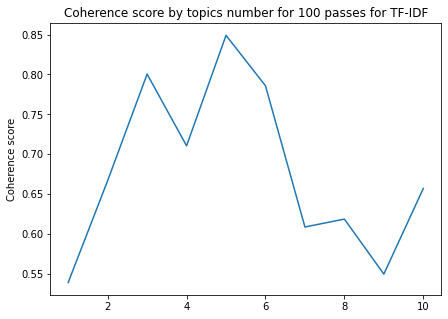

In [23]:
# Best number of topics for TF-IDF

plotT, list_modelT, list_bowT = best_topics_tfidf(final_list, max_num=10, passes=100 ,workers=4)

In [ ]:
# Save plot as you wish

plotT.savefig(input("Enter plot name with '' : ") + '_tfidf_topics.svg')

100%|██████████| 10/10 [27:53<00:00, 167.37s/it]


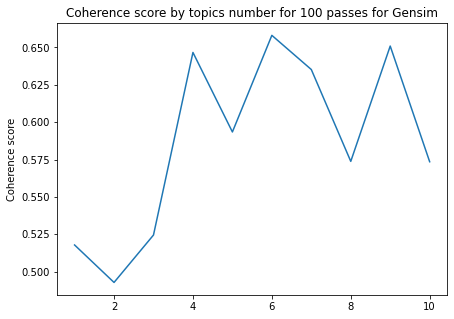

In [24]:
# Best number of topics for Gensim

plotG, list_modelG, list_bowG = best_topics_gensim(final_list, max_num=10, passes=100, iterations=100)

In [ ]:
# Save plot as you wish

plotG.savefig(input("Enter plot name with '' : ") + '_gensim_topics.svg')

In [ ]:
#Choose the best topics number and save it to a CSV
# For each topic a new column - where 'n' is the number of topic
# For each row percent of each topic

topic_to_df(n = 5, save_name='060321_Gensim4', list_model = list_modelG, list_bow = list_bowG)

In [29]:
# Model to dataframe - choose between 'list_modelT[n]' or 'list_modelG[n]'
# Where 'n' is the number of the topic in the list (begin at 0 not 1)

df_model = model_to_dataframe(lda_model = list_modelT[4] )
df_model

,Topic_No,Keywords
0,0.0,"[(venus, 0.01469376), (luna, 0.002916159), (ta..."
1,1.0,"[(moon, 0.011865485), (nightsky, 0.006039405),..."
2,2.0,"[(peace, 0.0015821204), (love, 0.0015814867), ..."
3,3.0,"[(gemini, 0.0016108259), (taurus, 0.0013117561..."
4,4.0,"[(moon, 0.0014268896), (astroloji, 0.001340408..."


In [31]:
# Save LDA model dataframe as you wish

df_model.to_csv(input("Enter Dataframe name with '' : ") + '_model.csv')

Enter Dataframe name with '' :  060321_TFIDF5


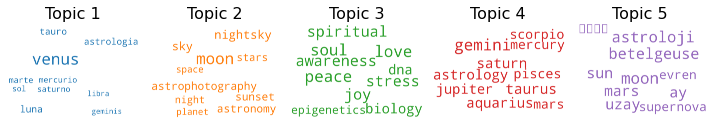

In [30]:
# Model to dataframe - choose between 'list_modelT[n]' or 'list_modelG[n]'
# Where 'n' is the number of the topic in the list (begin at 0 not 1)

plot = wordcloud(lda_model = list_modelT[4])

In [ ]:
# Save Wordcloud plot as you wish

plot.savefig(input("Enter plot name with '' : ") + '_wordcloud.svg')

In [ ]:
# Model to dataframe - choose between 'list_modelT[n]' or 'list_modelG[n]'
# Where 'n' is the number of the topic in the list (begin at 0 not 1)

plot = word_count_topic_keywords(lda_model= list_modelG[3], list_lemma = final_list)

In [ ]:
# Save word count and topic keywords plot as you wish

plot.savefig(input("Enter plot name with '' : ") + '_word_count_topic_keywords.svg')

In [27]:
# Model to dataframe - choose between 'list_modelT[n]' or 'list_modelG[n]'
# Where 'n' is the number of the topic in the list (begin at 0 not 1)
# Choose under which name to save the visualisation with 'name_html'

lda_vis = LDA_vis(lda_model=list_modelG[5], list_lemma=final_list, name_html='060321_TFIDF6_LDAvis')

/Users/JR/.pyenv/versions/topic/lib/python3.6/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [12/Mar/2021 08:59:09] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Mar/2021 08:59:09] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [12/Mar/2021 08:59:09] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [12/Mar/2021 08:59:09] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [12/Mar/2021 08:59:10] code 404, message Not Found
127.0.0.1 - - [12/Mar/2021 08:59:10] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...
